# Guia de procesamiento de una Serie Temporal

> Pedro Juan Torres González


1. Visualizar Datos y Estadisticas
1. Curación de Datos
    * Valores Faltantes
    * Valores Atipicos
1. Transformaciones Temporales y Agregación
    * Resample a escala (horas-dias-semanas)
    * Tendencia, Estacionalidad y Residuales
    * Escalado y normalización
        * Realizar normalización sobre train->entrenar->validacion con test_normalizado usando misma normalizacion que para train
    * Diferenciacion

1. Lags y Medias Deslizantes
1. Verificación ESTACIONARIEDAD
    * Prueba ADF
        * Si no es estacionaria -> diferenciacion y eliminación tendencia
1. División de datos
    * sklearn.model_selection.TimeSeriesSplit()
1. Modelado y Evaluación
    * metricas: RMSE, MAE, MAPE

## Carga de datos

In [2]:
from crate import client

HOST_CRATE="http://atd-z32togop.cloud.uco.es:4200"

# Conectamos con CrateDB
connection = client.connect(HOST_CRATE, username="crate")
cursor = connection.cursor()
# Consultamos las tablas existentes en CrateDB
cursor.execute("SHOW TABLES")
tables = cursor.fetchall()
print("Tablas disponibles:", tables)

Tablas disponibles: [['etairquality'], ['etestacion_meteo'], ['md_ets_metadata']]


In [43]:
import pandas as pd

def query_to_dataframe(crate_host, query, username="crate"):
    """
    Ejecuta una consulta en CrateDB y devuelve los resultados como un DataFrame de pandas.

    :param crate_host: Dirección del servidor CrateDB (por ejemplo, "http://localhost:4200/")
    :param query: Consulta SQL a ejecutar
    :param username: Usuario para la conexión (por defecto "crate")
    :return: pandas DataFrame con los resultados de la consulta
    """
    try:
        # Conexión a CrateDB
        connection = client.connect(crate_host, username=username)
        cursor = connection.cursor()

        # Ejecutar la consulta
        cursor.execute(query)

        # Obtener las columnas de la consulta
        columns = [col[0] for col in cursor.description]

        # Obtener los resultados de la consulta
        data = cursor.fetchall()

        # Convertir los resultados a un DataFrame de pandas
        df = pd.DataFrame(data, columns=columns)

        # Cerrar la conexión
        cursor.close()
        connection.close()

        return df

    except Exception as e:
        print("Error en la consulta:", e)
        return None



##################
# Obtener datos de crate
##################

query= """ 
SELECT entity_id, time_index, no2, so2, o3, pm10, pm25
FROM "mtatdfiware"."etestacion_meteo"
WHERE entity_id LIKE 'COCOR_LEPANTO' """ # Esta consulta es la misma que hacemos en el portal de crate para buscar cierta tabla, en este ejemplo vamos a trabajar con los datos de COCOR_LEPANTO
cursor.execute(query)

df=query_to_dataframe(HOST_CRATE, query,"crate")

#Eliminamos columna entity_id
df.drop(columns=["entity_id"],inplace=True)

df.dropna(inplace=True)

#Convertimos la columna time_index como indice del df
df["time_index"]=pd.to_datetime(df["time_index"],unit="ms")
# #ordenamos de mas antiguo a mas reciente
df.sort_values("time_index", inplace=True)
df.set_index("time_index", inplace=True)

print(df.head(),"\n")
print("Dimension df:", df.shape,"\n")
print("Tipos de datos de las columnas:\n",df.dtypes)
print("\nValores nulos por columna:\n",df.isnull().sum())

                      no2  so2      o3     pm10    pm25
time_index                                             
2022-10-04 01:00:00  13.0  3.0  59.750   95.940  31.579
2022-10-04 02:00:00  10.0  3.0  55.500   98.685  32.330
2022-10-04 03:00:00  10.0  3.0  50.500  100.800  32.860
2022-10-04 05:00:00  11.0  3.0  41.375  104.400  33.390
2022-10-04 06:00:00  14.0  2.0  41.000  106.065  33.743 

Dimension df: (11286, 5) 

Tipos de datos de las columnas:
 no2     float64
so2     float64
o3      float64
pm10    float64
pm25    float64
dtype: object

Valores nulos por columna:
 no2     0
so2     0
o3      0
pm10    0
pm25    0
dtype: int64


## Visualización

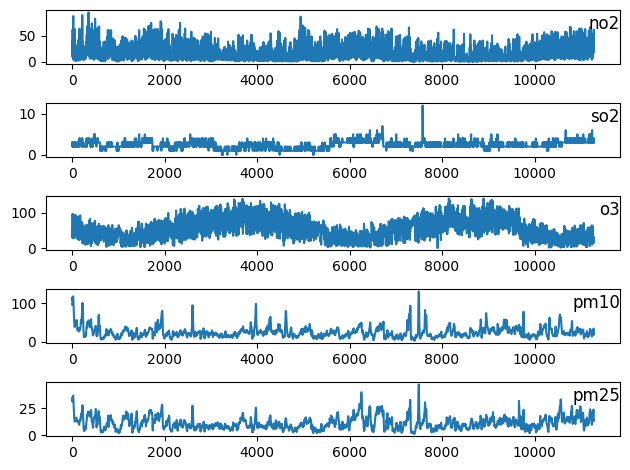

In [14]:
import matplotlib.pyplot as plt

# groups' es una lista de índices de columnas que deseas graficar
groups = [0, 1, 2, 3, 4]  # Ajusta esto según tus columnas
values = df.values  # Asegúrate de que 'df' sea tu DataFrame

plt.figure()
for i, group in enumerate(groups, start=1):
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')

plt.tight_layout()
plt.show()

In [12]:
print(df.describe())

                no2           so2            o3          pm10          pm25
count  11788.000000  11618.000000  11908.000000  11927.000000  11910.000000
mean      14.313280      2.369771     54.126830     25.191095     11.576375
std       12.629462      0.806568     29.643292     14.413412      5.750347
min        0.000000      0.000000      1.000000      2.796000      1.545000
25%        5.719750      2.000000     30.250000     15.878000      7.480000
50%       10.000000      2.000000     52.000000     22.052000     10.440000
75%       19.000000      3.000000     75.375000     30.508000     14.697000
max       95.000000     12.000000    141.250000    130.045000     47.144000


##

In [15]:
print("Correlación entre las variables")
print(df.corr())

Correlación entre las variables
           no2       so2        o3      pm10      pm25
no2   1.000000  0.289917 -0.294815  0.115105  0.264436
so2   0.289917  1.000000 -0.261951  0.156121  0.415775
o3   -0.294815 -0.261951  1.000000 -0.000357 -0.243952
pm10  0.115105  0.156121 -0.000357  1.000000  0.804182
pm25  0.264436  0.415775 -0.243952  0.804182  1.000000


## Remuestreo y tendencias

Resample por Semanas:
 time_index
2022-10-09    58.934193
2022-10-16    56.636250
2022-10-23    40.797711
2022-10-30    37.155048
2022-11-06    36.155768
Freq: W-SUN, Name: o3, dtype: float64
Media Deslizante 3dias (aprox):
 time_index
2022-10-04 01:00:00   NaN
2022-10-04 02:00:00   NaN
2022-10-04 03:00:00   NaN
2022-10-04 05:00:00   NaN
2022-10-04 06:00:00   NaN
2022-10-04 07:00:00   NaN
2022-10-04 09:00:00   NaN
2022-10-04 14:00:00   NaN
2022-10-04 20:00:00   NaN
2022-10-04 22:00:00   NaN
Name: o3, dtype: float64


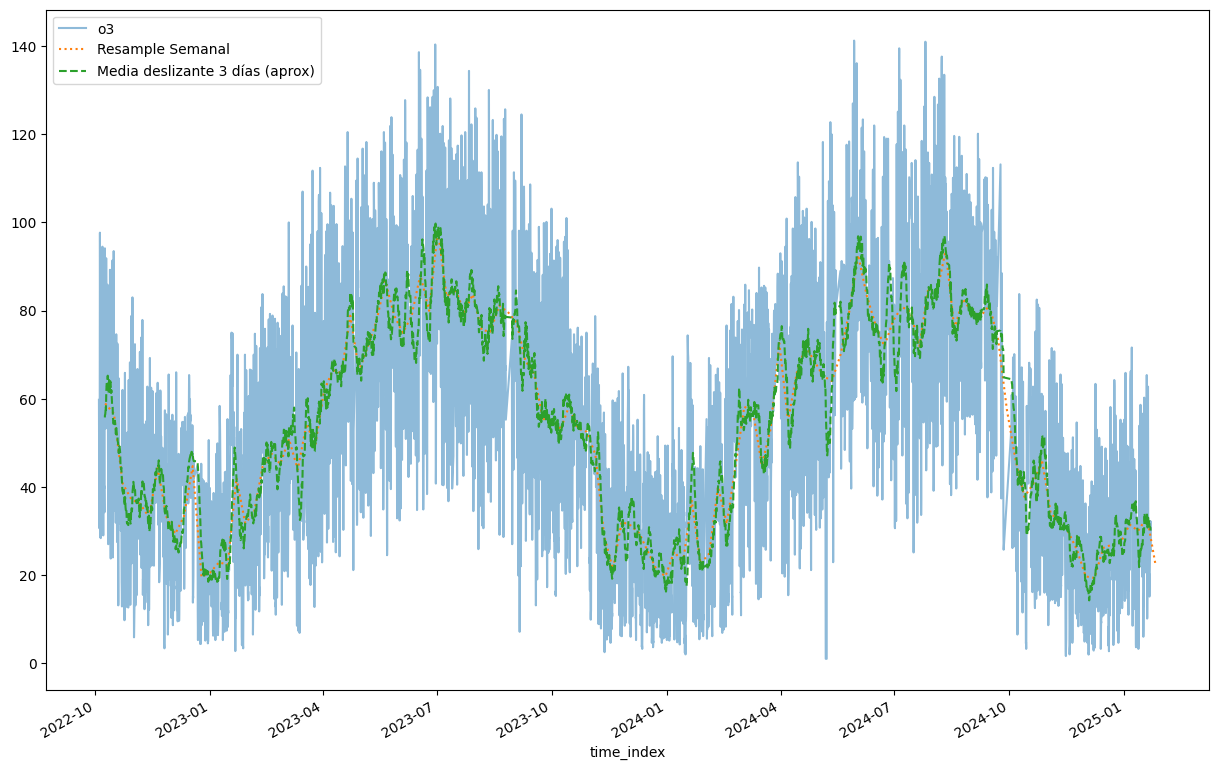

In [39]:
o3=df["o3"]

# Resampleamos por dias
o3_resample = o3.resample('W').mean()
print("Resample por Semanas:\n",o3_resample.head())

# Calculamos media deslizante 
o3_roll = o3.rolling(window=72).mean()
print("Media Deslizante 3dias (aprox):\n", o3_roll.head(10))


# Visualizamos los datos resampleados con su media deslizante
ax=o3.plot(alpha=0.5, style='-',figsize=(15,10)) #guardamos los ejes para reutilizarlos
o3_resample.plot(style=':', ax=ax, label='Resample Semanal')
o3_roll.plot(style='--', ax=ax, label='Media deslizante 3 días (aprox)')
ax.legend();

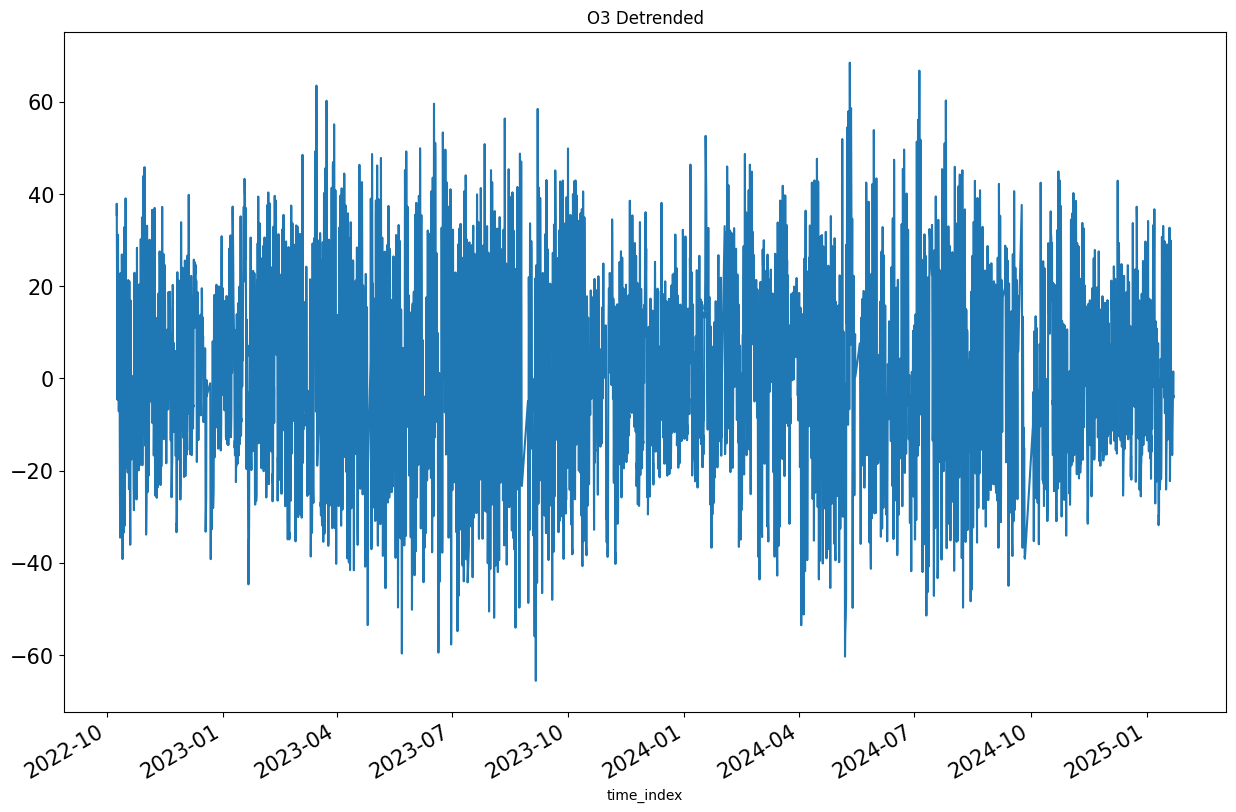

In [33]:
################################
# Eliminamos tendencia de la serie
################################

# Eliminamos la tendencia de la serie
o3_detrended = o3 - o3_roll
o3_detrended.plot(figsize=(15,10),linewidth=1.5,fontsize=15, title='O3 Detrended')
plt.show()

In [1]:
###############################################
# TENDENCIA - ESTACIONALIDAD - RESIDUOS
###############################################



from statsmodels.tsa.seasonal import seasonal_decompose
x = o3_resample
x.index = pd.to_datetime(x.index)
x = x.astype(float) # force float
x=x.asfreq('w')
period=24
decomposition = seasonal_decompose(x,period=period)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(x, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

NameError: name 'o3_resample' is not defined

## ADF Test

In [50]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > ¿Es estacionaria la serie {}?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Estadístico = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Valores críticos :')
    for k, v in dftest[4].items():
        print('\t{}: {} - La serie es {} estacionaria con una confianza de {}%'.format(k, v, 'no' if v<dftest[0] else '', 100-int(k[:-1])))

### Representar los estadísticos para comprobar la estacionariedad
def test_stationarity(timeseries, title):
    
    # Determinar los estadísticos
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='media deslizante');
    ax.plot(rolstd, label='desviación típica deslizante (x10)');
    ax.legend()

 > ¿Es estacionaria la serie Original?
Estadístico = -4.911
P-value = 0.000
Valores críticos :
	1%: -3.4309316106391305 - La serie es  estacionaria con una confianza de 99%
	5%: -2.86179704044158 - La serie es  estacionaria con una confianza de 95%
	10%: -2.5669068175153567 - La serie es  estacionaria con una confianza de 90%


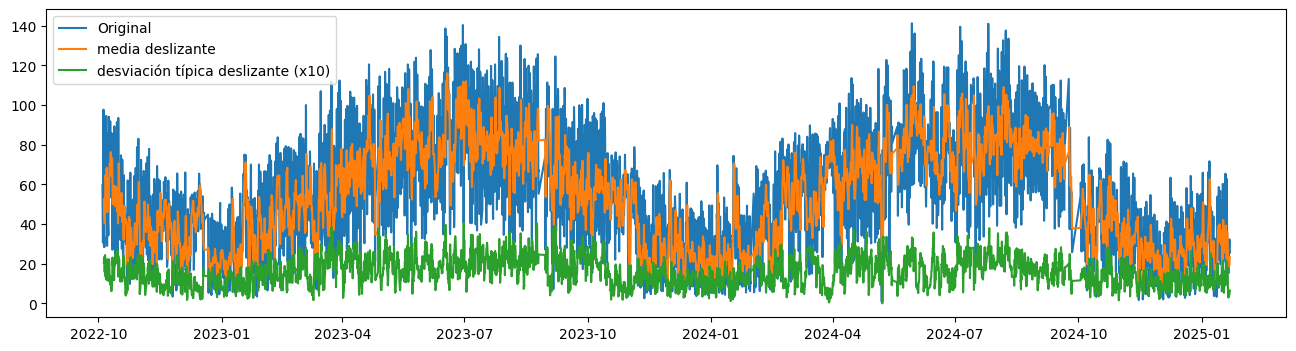

In [51]:
ADF_test(o3, "Original")
test_stationarity(o3, "Original")

 > ¿Es estacionaria la serie Detrended?
Estadístico = -17.124
P-value = 0.000
Valores críticos :
	1%: -3.430935359125964 - La serie es  estacionaria con una confianza de 99%
	5%: -2.86179869690675 - La serie es  estacionaria con una confianza de 95%
	10%: -2.5669076992471047 - La serie es  estacionaria con una confianza de 90%


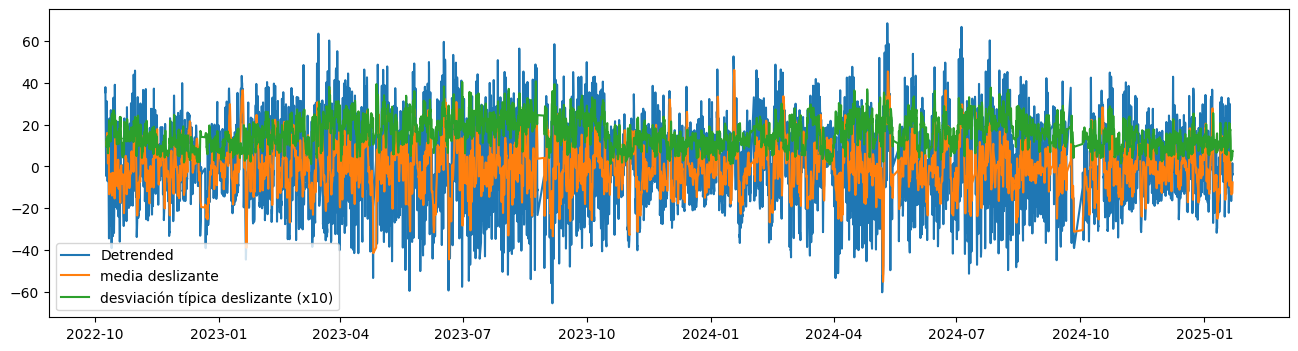

In [52]:
ADF_test(o3_detrended, "Detrended")
test_stationarity(o3_detrended, "Detrended")

 > ¿Es estacionaria la serie Shifted?
Estadístico = -13.589
P-value = 0.000
Valores críticos :
	1%: -3.4309356212325715 - La serie es  estacionaria con una confianza de 99%
	5%: -2.8617988127322 - La serie es  estacionaria con una confianza de 95%
	10%: -2.5669077609006794 - La serie es  estacionaria con una confianza de 90%


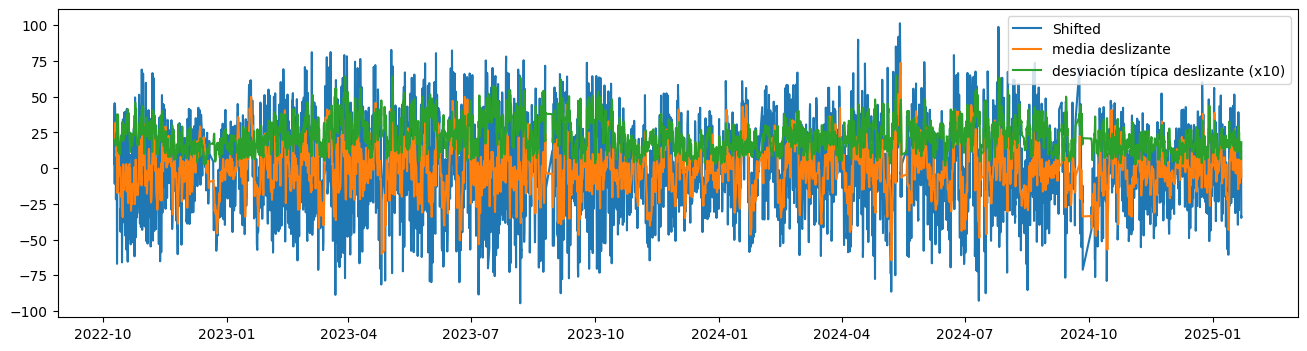

In [53]:
o3_shifted = o3 - o3.shift(76)
ADF_test(o3_shifted, "Shifted")
test_stationarity(o3_shifted, "Shifted")

Text(0.5, 1.0, 'Autocorrelation Function')

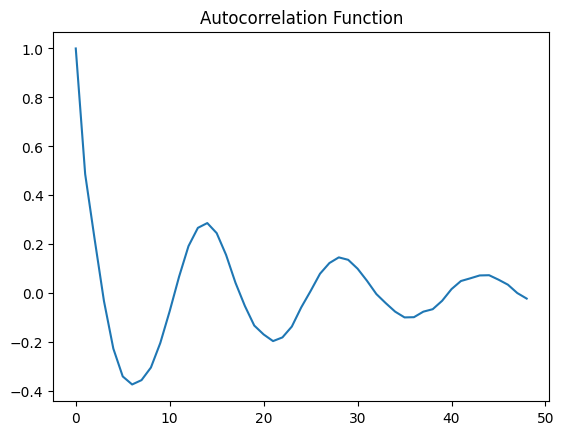

In [54]:
from statsmodels.tsa.stattools import acf

o3_diff = o3.diff().dropna() # El primer término será NA
lag_acf = acf(o3_diff, nlags=48, fft=True)
plt.plot(lag_acf)
plt.title('Autocorrelation Function')